## Plot spike trains
-------

Example notebook demonstrating simple functions in SynapticConn for plotting spike trains. 

In [1]:
import os
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

os.chdir('../..')
print(os.getcwd())

from synapticonn.plots import plot_acg, plot_ccg
from synapticonn.postprocessing import compute_crosscorrelogram
from synapticonn.postprocessing import compute_autocorrelogram

import synapticonn as synapticonn

/Users/michael.zabolocki/Desktop/code/SynaptiConn


Load data. 

In [2]:
data_fpath = pathlib.Path('tests', 'BD0187_spikesorting_array.pkl')

# open pickle
all_units = np.load(data_fpath, allow_pickle=True)
all_units = all_units['spike_time_set']
# spike_train_1 = all_units[0]/30_000  # unit 0
# spike_train_2 = all_units[1]/30_000  # unit 1

Set parameters.

In [3]:
srate = 30_000
bin_size_ms = 0.5
max_lag_ms = 25

Initialize the object.

In [4]:
snc = synapticonn.SynaptiConn(all_units, bin_size_ms=1, max_lag_ms=100, srate=30_000, recording_length=600)

Check the loaded spike units.

In [5]:
spk_unit_report = snc.report_spike_units()
pd.DataFrame(spk_unit_report)

,unit_id,n_spikes
0,5,302
1,1,1152
2,0,918
3,16,524
4,17,315
5,18,195
6,15,192
7,4,299
8,3,277


Compute the autocorrelogram for select unit IDs.

Plotting autocorrelogram for spike units: [ 3  1  0  3  4 18 15]


AttributeError: Rectangle.set() got an unexpected keyword argument 'figsize'

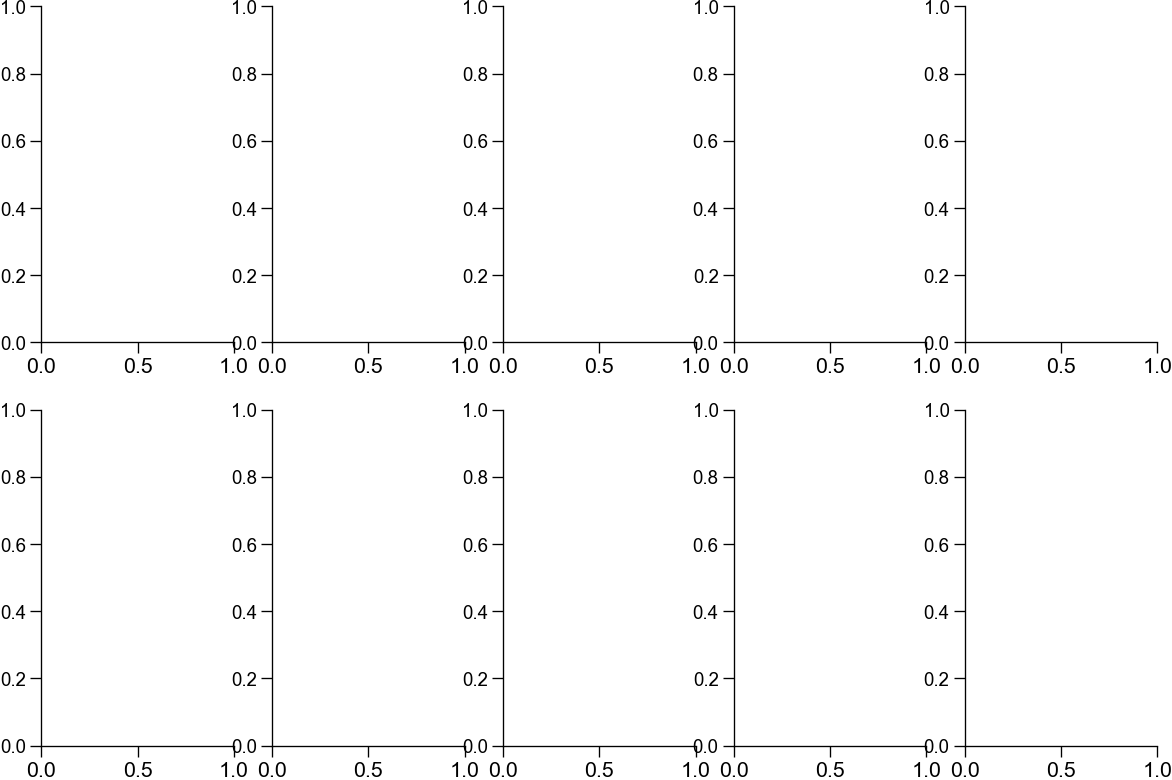

In [9]:
snc.plot_autocorrelogram(spike_units_to_plot=[3,1,0,3,4,18,15], color='red', figsize=(10,10))

# ensure that the input is a list type 
# need to build in checks for the type inserts
# check if any units were not able to be found / matched
# fix the check_ax 
# is ax needed here?
# add a reset option for the bins and lags for plotting etc.
# add a function to check the lags and the bins for this etc.

Plot spike train.

In [7]:
# import matplotlib.pyplot as plt

# n_cells = all_units['unit_t'].shape[1]

# # plot spike trains for each cell
# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# for cell in range(n_cells):
#     ax.eventplot(all_units['unit_t'][0][cell].T, lineoffsets=cell, colors='k', linewidths=0.5)
    
# # axis labels
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Cell #')

# plt.show()

Plot autocorrelograms for individual cells.

NameError: name 'spike_train_1' is not defined

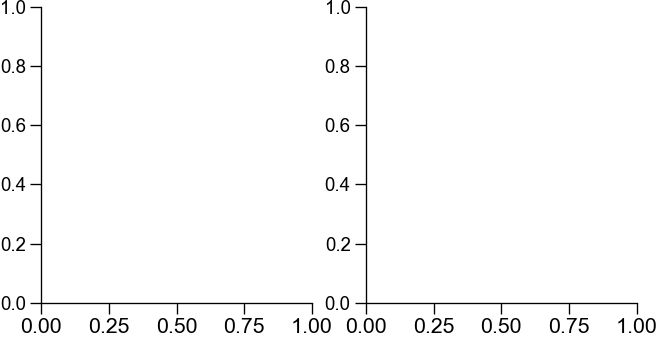

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=False, sharex=True)

# bin parameters
bin_size_ms = 1
max_lag_ms = 20

plot_acg(spike_train_1*1000, bin_size_ms, max_lag_ms, color='red', ax=ax[0])
ax[0].set_title('Unit 0')

plot_acg(spike_train_2*1000, bin_size_ms, max_lag_ms, color='blue', ax=ax[1], file_name='test', file_path='.', extension='png')
ax[1].set_title('Unit 1')
ax[1].set_ylabel('')

In [ ]:
lags, autocorr = compute_autocorrelogram(spike_train_1*1000, 0.5, max_lag_ms)
lags, autocorr

NameError: name 'spike_train_1' is not defined

In [ ]:
idx = np.where((lags > -2) & (lags < 2))  # isolate in a 2ms window using the lags
total_refractory_violations = np.sum(autocorr[idx])
proportion_refractory_violations = total_refractory_violations / len(spike_train_1)

print(f'Total refractory violations: {total_refractory_violations}')
print(f'Proportion refractory violations: {proportion_refractory_violations*100}')

# print out the binning etc etc. for this ...
# identify units with poor ACG / noisy ACGs
# add an option to remove these units from the analysis --> build this in to the object? Will make it then easier to manipulate the objects here

NameError: name 'lags' is not defined

Cross-correlogram plots between units.

In [ ]:
srate = 30_000

labels = list(all_units.keys())
spike_times_set = list(all_units.values())

if srate: 
    spike_times_set = [spike_times/srate for spike_times in spike_times_set]

bin_size_ms = 0.5
max_lag_ms = 25
cross_correlograms_data = compute_crosscorrelogram(spike_times_set, labels, bin_size_ms, max_lag_ms)

In [ ]:
spike_times_set

[array([1.23333333e-03, 3.36922222e-02, 8.10622222e-02, 1.07325556e-01,
        1.33018889e-01, 1.78038889e-01, 2.33292222e-01, 2.75311111e-01,
        3.20362222e-01, 4.31533333e-01, 5.20292222e-01, 5.59391111e-01,
        6.38343333e-01, 6.80454444e-01, 7.09151111e-01, 7.75391111e-01,
        9.95876667e-01, 1.02963222e+00, 1.04921444e+00, 1.15791333e+00,
        1.29664000e+00, 1.48373444e+00, 1.80222556e+00, 1.82817333e+00,
        2.11658000e+00, 2.13794111e+00, 2.16287333e+00, 2.42871667e+00,
        2.45384889e+00, 2.47967667e+00, 2.49498667e+00, 2.61410556e+00,
        2.75946444e+00, 3.23364889e+00, 3.31713333e+00, 3.36552333e+00,
        3.45456000e+00, 3.47806667e+00, 3.51797111e+00, 3.57981444e+00,
        3.63270333e+00, 3.71561667e+00, 3.78882889e+00, 3.81964667e+00,
        3.92372667e+00, 4.04040889e+00, 4.10383333e+00, 4.17118889e+00,
        4.24340667e+00, 4.29872222e+00, 4.32752778e+00, 4.38948000e+00,
        4.42768444e+00, 4.49388556e+00, 4.63266778e+00, 4.669920

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

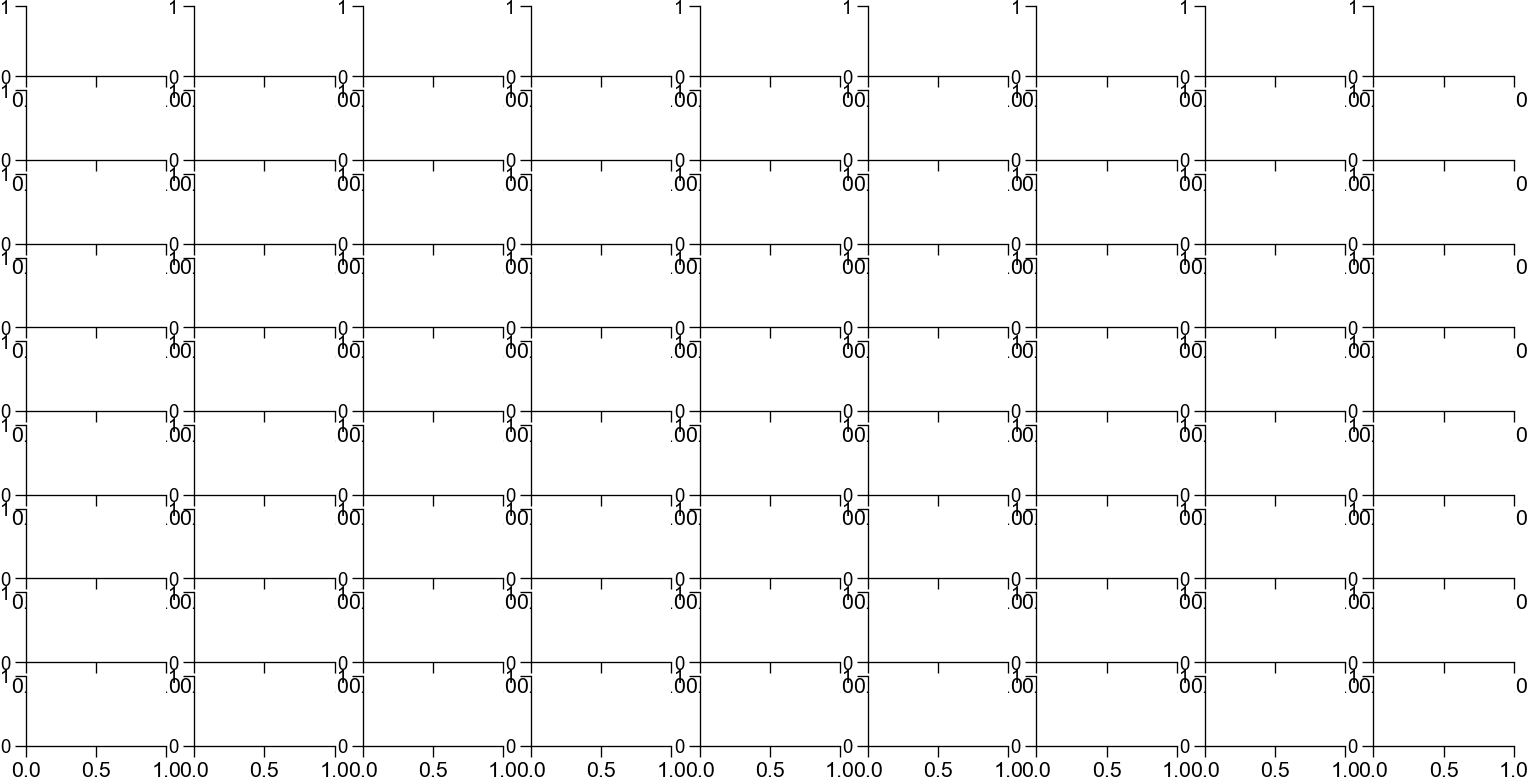

In [ ]:
# fig, ax = plt.subplots(9, 9, figsize=(10, 10), sharey=False, sharex=True)
plot_ccg(cross_correlograms_data, labels=labels, ax=None, figsize=(20, 10))
# file_name='test', file_path='.', extension='png'

In [ ]:
# file_name='test', file_path='.', extension='png'

TO DO: 

- Test units

- Plot for multiple ACGS
    - option to subselect for only 1
    - similar to the CG processing?


- Style is not being fitted globally --> the decorator is useless?

- Check the distances between the units?

- Document all the steps in place to check this all out ...

- Option to only plot certain pairs ...

- Option to improve the labels here for the units? Check it with different input types

- Build a core object which allows for batch-processing, but also adds in the srates etc. of the recordings

- Option to cross-check with the distances???

- Add checks for the correlograms